In [2]:
#!/usr/bin/env python3

import pickle as pk
import sys
import time as tm
import argparse
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data.dataset import Dataset
from typing import Iterator, Optional
import optuna


from pathlib import Path
from typing import cast
import h5py
import pickle


sns.set_theme()

batch_size = 50
num_workers = 10

In [2]:
print(optuna.__version__)


3.5.0


In [3]:
p_latent_space = 300
num_epochs = 1
n_phen = 25

############

n_geno = 100000
n_alleles = 2
latent_space_g = 1000
num_epochs_gen = 1

############

gp_latent_space = p_latent_space
epochs_gen_phen = 2

l1_lambda = 0.00000000000001
l2_lambda = 0.00000000000001

#l1_lambda = 0.08
#l2_lambda = 0.08

In [4]:
def convert_pickle_to_hdf5(pickle_path: Path, hdf5_path: Path, gzip: bool = True) -> Path:
    data = pickle.load(open(pickle_path, "rb"))
    str_dt = h5py.string_dtype(encoding="utf-8")

    with h5py.File(hdf5_path, "w") as h5f:
        metadata_group = h5f.create_group("metadata")

        loci_array = np.array(data["loci"], dtype=str_dt)
        metadata_group.create_dataset("loci", data=loci_array)

        pheno_names_array = np.array(data["phenotype_names"], dtype=str_dt)
        metadata_group.create_dataset("phenotype_names", data=pheno_names_array)

        strains_group = h5f.create_group("strains")

        for idx, strain_id in enumerate(data["strain_names"]):
            strain_grp = strains_group.create_group(strain_id)

            pheno = np.array(data["phenotypes"][idx], dtype=np.float64)
            strain_grp.create_dataset("phenotype", data=pheno)

            genotype = np.array(data["genotypes"][idx], dtype=np.int8)
            strain_grp.create_dataset(
                "genotype",
                data=genotype,
                chunks=True,
                compression="gzip" if gzip else None,
            )

        print(f"{hdf5_path} generated from {pickle_path}.")

    return hdf5_path

class BaseDataset(Dataset):
    def __init__(self, hdf5_path: Path) -> None:
        self.h5 = h5py.File(hdf5_path, "r")

        self._strain_group = cast(h5py.Group, self.h5["strains"])
        self.strains: list[str] = list(self._strain_group.keys())

    def __len__(self) -> int:
        return len(self._strain_group)


class GenoPhenoDataset(BaseDataset):
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        strain = self.strains[idx]

        strain_data = cast(Dataset, self._strain_group[strain])

        # Note: genotype is being cast as float32 here, reasons not well understood.
        phens = torch.tensor(strain_data["phenotype"][:], dtype=torch.float32)
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()

        return phens, gens

class PhenoDataset(BaseDataset):
    def __getitem__(self, idx: int):
        strain = self.strains[idx]

        strain_data = cast(Dataset, self._strain_group[strain])

        # Note: genotype is being cast as float32 here, reasons not well understood.
        phens = torch.tensor(strain_data["phenotype"][:], dtype=torch.float32)


        return phens
###########
class GenoDataset(BaseDataset):
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        strain = self.strains[idx]

        strain_data = cast(Dataset, self._strain_group[strain])

        # Note: genotype is being cast as float32 here, reasons not well understood.
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()

        return  gens

#if __name__ == "__main__":
#    parser = argparse.ArgumentParser(description="Convert a Dave's pickle data to an HDF5 file.")
#    parser.add_argument("pickle_path", type=Path, help="Path to the input pickle file.")
#    parser.add_argument("hdf5_path", type=Path, help="Path to the output HDF5 file.")
#    parser.add_argument("gzip", type=bool, help="Gzip datasets (decreases read speed).")
#    args = parser.parse_args()

    #convert_pickle_to_hdf5(args.pickle_path, args.hdf5_path, args.gzip)

In [5]:
#convert_pickle_to_hdf5('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.pk', 'gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.hdf5')

In [5]:
train_data_pheno = PhenoDataset('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_train.hdf5')
test_data_pheno = PhenoDataset('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.hdf5')

train_data_geno = GenoDataset('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_train.hdf5')
test_data_geno = GenoDataset('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.hdf5')

train_data_gp = GenoPhenoDataset('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_train.hdf5')
test_data_gp = GenoPhenoDataset('gpatlas/test_sim_WF_1kbt_10000n_5000000bp_test.hdf5')


In [6]:

train_loader_pheno = torch.utils.data.DataLoader(
    dataset=train_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_pheno = torch.utils.data.DataLoader(
    dataset=test_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)



train_loader_geno = torch.utils.data.DataLoader(
    dataset=train_data_geno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_geno = torch.utils.data.DataLoader(
    dataset=test_data_geno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)


train_loader_gp = torch.utils.data.DataLoader(
    dataset=train_data_gp, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_gp = torch.utils.data.DataLoader(
    dataset=test_data_gp, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# gencoder
class GQ_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=n_loci, out_features=N),
            nn.BatchNorm1d(N, momentum=0.8),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=g_latent_dim),
            nn.BatchNorm1d(g_latent_dim, momentum=0.8),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# gendecoder
class GP_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=n_loci),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [29]:

def objective(trial: optuna.Trial,
             train_loader,
             test_loader,
             n_geno: int,
             n_alleles: int,
             device: torch.device,
             num_epochs: int = 50) -> float:

    # Hyperparameters to optimize
    global latent_space_g  # Make it global so the classes can access it
    latent_space_g = trial.suggest_int('latent_space_g', 100, 3000)
    gen_noise = trial.suggest_float('gen_noise', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Constants
    EPS = 1e-15
    adam_b = (0.5, 0.999)
    n_loci = n_geno * n_alleles

    # Initialize models
    GQ = GQ_net(n_loci=n_loci).to(device)
    GP = GP_net(n_loci=n_loci).to(device)

    # Optimizers
    optim_GQ_enc = torch.optim.Adam(GQ.parameters(), lr=learning_rate, betas=adam_b)
    optim_GP_dec = torch.optim.Adam(GP.parameters(), lr=learning_rate, betas=adam_b)

    # Training loop
    for epoch in range(num_epochs):
        GQ.train()
        GP.train()

        epoch_losses = []

        for i, gens in enumerate(train_loader):
            batch_size = gens.shape[0]

            GP.zero_grad()
            GQ.zero_grad()

            #gens = gens.reshape(gens.shape[0], -1)
            #gens = gens[:, :n_loci]

            # Apply noise
            noise_prob = 1 - gen_noise
            pos_noise = np.random.binomial(1, noise_prob / 2, gens.shape)
            neg_noise = np.random.binomial(1, noise_prob / 2, gens.shape)

            noise_gens = torch.tensor(
                np.where((gens + pos_noise - neg_noise) > 0, 1, 0),
                dtype=torch.float32
            ).to(device)

            gens = gens.to(device)

            z_sample = GQ(noise_gens)
            X_sample = GP(z_sample)

            g_recon_loss = F.binary_cross_entropy(X_sample + EPS, gens + EPS)

            # L1 and L2 regularization
            l1_reg = torch.linalg.norm(torch.sum(GQ.encoder[0].weight, axis=0), 1)
            l2_reg = torch.linalg.norm(torch.sum(GQ.encoder[0].weight, axis=0), 2)

            total_loss = g_recon_loss + l1_reg * 0 + l2_reg * 0

            total_loss.backward()
            optim_GQ_enc.step()
            optim_GP_dec.step()

            epoch_losses.append(float(total_loss.detach()))

        # Test set evaluation
        if epoch % 1 == 0:
            GQ.eval()
            GP.eval()
            test_losses = []

            with torch.no_grad():
                for gens in test_loader:
                    #gens = gens.reshape(gens.shape[0], -1)
                    gens = gens.to(device)
                    #gens = gens[:, :n_loci].to(device)

                    z_sample = GQ(gens)
                    X_sample = GP(z_sample)

                    test_loss = F.binary_cross_entropy(X_sample + EPS, gens + EPS)
                    test_losses.append(float(test_loss))

            avg_test_loss = np.mean(test_losses)
            print(f"Epoch {epoch}, Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss


In [30]:

# Create study
study = optuna.create_study(direction='minimize')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run optimization
n_trials = 3  # Start small for testing

n_trials = 50
try:
    # Create a list to store results as we go
    trial_results = []

    study.optimize(
        lambda trial: objective(
            trial=trial,
            train_loader=train_loader_geno,
            test_loader=test_loader_geno,
            n_geno=n_geno,
            n_alleles=n_alleles,
            device=device,
            num_epochs=1
        ),
        n_trials=n_trials,
        callbacks=[
            lambda study, trial: trial_results.append({
                'trial_number': trial.number,
                'params': trial.params,
                'value': trial.value,
                'state': trial.state.name
            })
        ]
    )

    print("\nStudy completed!")
    print(f"Best parameters found: {study.best_params}")
    print(f"Best value achieved: {study.best_value}")

    # Save results to CSV
    results_df = pd.DataFrame(trial_results)
    results_df.to_csv(f'optuna_trials_{timestamp}.csv', index=False)

    # Save detailed study information to JSON
    study_info = {
        'best_params': study.best_params,
        'best_value': study.best_value,
        'n_trials': n_trials,
        'datetime': timestamp,
        'all_trials': trial_results
    }

    with open(f'optuna_study_{timestamp}.json', 'w') as f:
        json.dump(study_info, f, indent=4)

    print(f"\nResults saved to:")
    print(f"- optuna_trials_{timestamp}.csv")
    print(f"- optuna_study_{timestamp}.json")

except Exception as e:
    print(f"Error details: {str(e)}")
    import traceback
    traceback.print_exc()

    # Save error information
    with open(f'optuna_error_{timestamp}.txt', 'w') as f:
        f.write(f"Error occurred: {str(e)}\n")
        traceback.print_exc(file=f)

[I 2025-02-12 23:14:58,000] A new study created in memory with name: no-name-46ade108-67f8-487b-90c3-ebcd2d50a934
[I 2025-02-12 23:17:58,062] Trial 0 finished with value: 0.45290089150269824 and parameters: {'latent_space_g': 45, 'gen_noise': 0.14464796479547146, 'learning_rate': 0.007447895896780988}. Best is trial 0 with value: 0.45290089150269824.


Epoch 0, Test Loss: 0.4529


[I 2025-02-12 23:20:00,007] Trial 1 finished with value: 0.45325903594493866 and parameters: {'latent_space_g': 46, 'gen_noise': 0.31190005349350086, 'learning_rate': 0.004686545907694202}. Best is trial 0 with value: 0.45290089150269824.


Epoch 0, Test Loss: 0.4533


[I 2025-02-12 23:22:09,844] Trial 2 finished with value: 0.6388294180234273 and parameters: {'latent_space_g': 43, 'gen_noise': 0.4213635539323288, 'learning_rate': 0.00010869448330659639}. Best is trial 0 with value: 0.45290089150269824.


Epoch 0, Test Loss: 0.6388

Study completed!
Best parameters found: {'latent_space_g': 45, 'gen_noise': 0.14464796479547146, 'learning_rate': 0.007447895896780988}
Best value achieved: 0.45290089150269824


In [31]:
plt.plot(g_rcon_loss)

NameError: name 'g_rcon_loss' is not defined

In [ ]:
geno_encodings = []
genos = []
geno_latent = []

# Set models to eval mode
GQ.eval()
GP.eval()

with torch.no_grad():  # Disable gradient computation for inference
    for gt in test_loader_geno:
        # Move data to device
        gt = gt.to(device)

        # Forward pass through autoencoder
        z_sample = GQ(gt)  # Encode
        X_sample = GP(z_sample)  # Decode

        # Store results
        genos.append(gt.cpu().numpy())
        geno_encodings.append(X_sample.cpu().numpy())
        geno_latent.append(z_sample.cpu().numpy())

        # Clean up memory
        del z_sample, X_sample
        if device.type == 'cuda':
            torch.cuda.empty_cache()

# Concatenate all batches and transpose
genos = np.concatenate(genos, axis=0).T
geno_encodings = np.concatenate(geno_encodings, axis=0).T
geno_latent = np.concatenate(geno_latent, axis=0).T

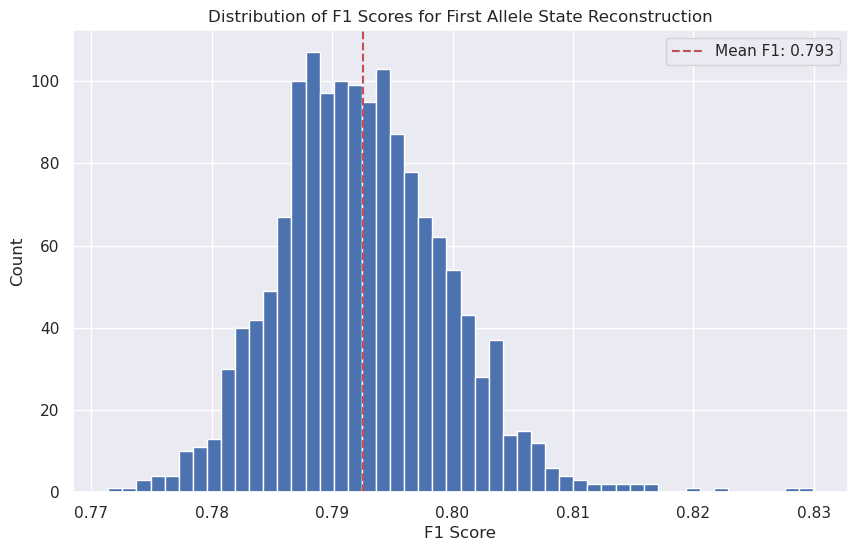

Average F1 Score: 0.793 ± 0.007


In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

f1_scores = []

# Set models to eval mode
GQ.eval()
GP.eval()

with torch.no_grad():
    for gt in test_loader_geno:
        gt = gt.to(device)

        # Forward pass through autoencoder
        z_sample = GQ(gt)
        X_sample = GP(z_sample)

        # Move to CPU and convert to numpy
        original = gt.cpu().numpy()
        reconstructed = X_sample.cpu().numpy()

        # Reshape to [batch_size, n_loci, 2] to separate alleles
        original = original.reshape(-1, n_geno, 2)
        reconstructed = reconstructed.reshape(-1, n_geno, 2)

        # Take just the first allele state for each locus
        original_allele1 = original[:, :, 0]
        reconstructed_allele1 = (reconstructed[:, :, 0] > 0.5).astype(int)

        # Calculate F1 score for each sample in the batch
        for orig, recon in zip(original_allele1, reconstructed_allele1):
            f1 = f1_score(orig, recon, average='macro')
            f1_scores.append(f1)

# Plot distribution of F1 scores
plt.figure(figsize=(10, 6))
plt.hist(f1_scores, bins=50)
plt.xlabel('F1 Score')
plt.ylabel('Count')
plt.title('Distribution of F1 Scores for First Allele State Reconstruction')
plt.axvline(np.mean(f1_scores), color='r', linestyle='dashed', label=f'Mean F1: {np.mean(f1_scores):.3f}')
plt.legend()
plt.show()

print(f"Average F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")